In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style="white", context='talk')
figure_folder = Path(r'figures/noise/')
figure_folder.mkdir(exist_ok=True)
mpl.rcParams['font.family'] = 'STIX Two Text'
mpl.rcParams['mathtext.fontset'] = 'stix'

In [4]:
from pymultifracs.psd import plot_psd, PSD
from pymultifracs.viz import plot_coef
from pymultifracs.simul import fbm, mrw
from pymultifracs.mfa import mf_analysis
from pymultifracs.wavelet import wavelet_analysis

import numpy as np

## Simulate FBM

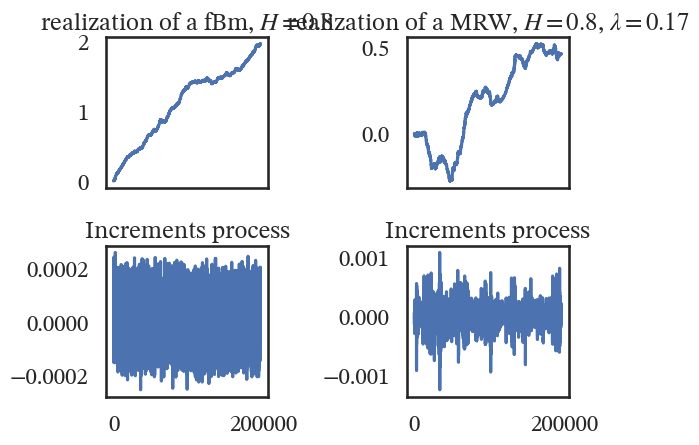

In [5]:
N = int(1.5 * 2 ** 17)
X = fbm(shape=N, H=0.8)
X_freq_drift = fbm(shape=N, H=0.3)
X_mrw = mrw(shape=N, H=0.8, lam=np.sqrt(0.05), L=N)

fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(X)
ax[0, 1].plot(X_mrw)
ax[0, 0].set(title='realization of a fBm, $H=0.8$', xticks=[])
ax[0, 1].set(title='realization of a MRW, $H=0.8$, $\lambda=0.17$', xticks=[])
ax[1, 0].plot(np.diff(X))
ax[1, 1].plot(np.diff(X_mrw))
ax[1, 0].set(title='Increments process')
ax[1, 1].set(title='Increments process')
plt.tight_layout()
# plt.ylabel('X')
# plt.xlabel('t')
plt.show()

In [6]:
X_diff = np.diff(X)
X_mrw_diff = np.diff(X_mrw)

### Ground truth

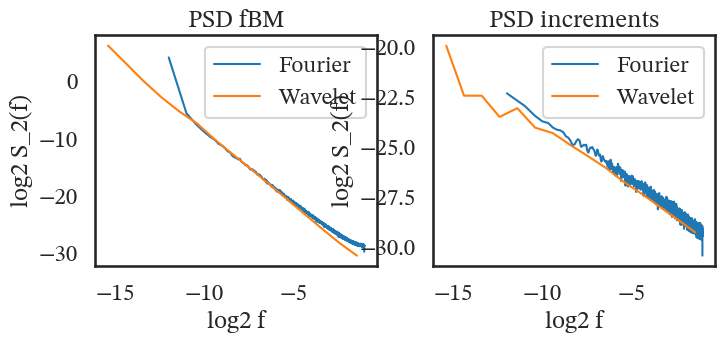

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plot_psd(X, 1, ax=ax[0])
ax[0].set(title='PSD fBM')
plot_psd(X_diff, 1, ax=ax[1])
ax[1].set(title='PSD increments')
plt.show()

In [74]:
WT = wavelet_analysis(X_diff, p_exp=2, j1=8, j2_reg=13, gamint=1, j2=14)

In [75]:
dwt, lwt = mf_analysis([WT.wt_coefs, WT.wt_leaders], scaling_ranges=[(6, WT.wt_leaders.j2_eff() - 2)])

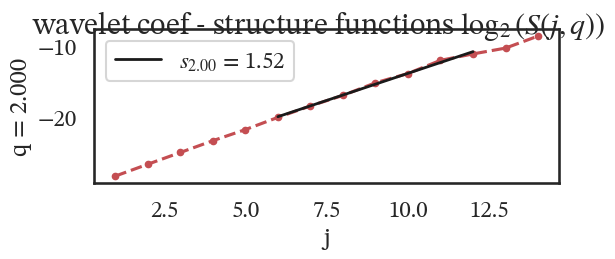

In [76]:
dwt.structure.plot(figsize=(6, 2))

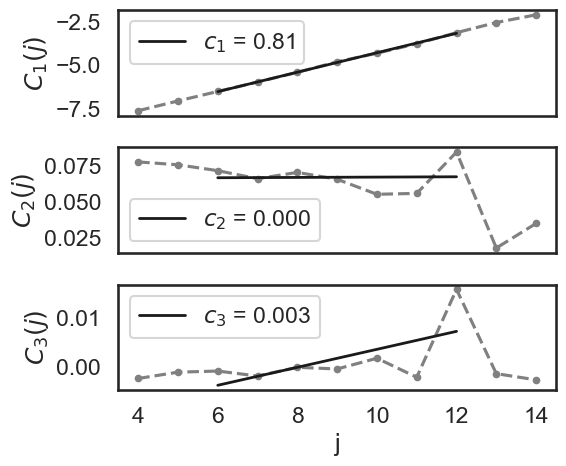

In [11]:
lwt.cumulants.plot(j1=4, figsize=(6, 5))

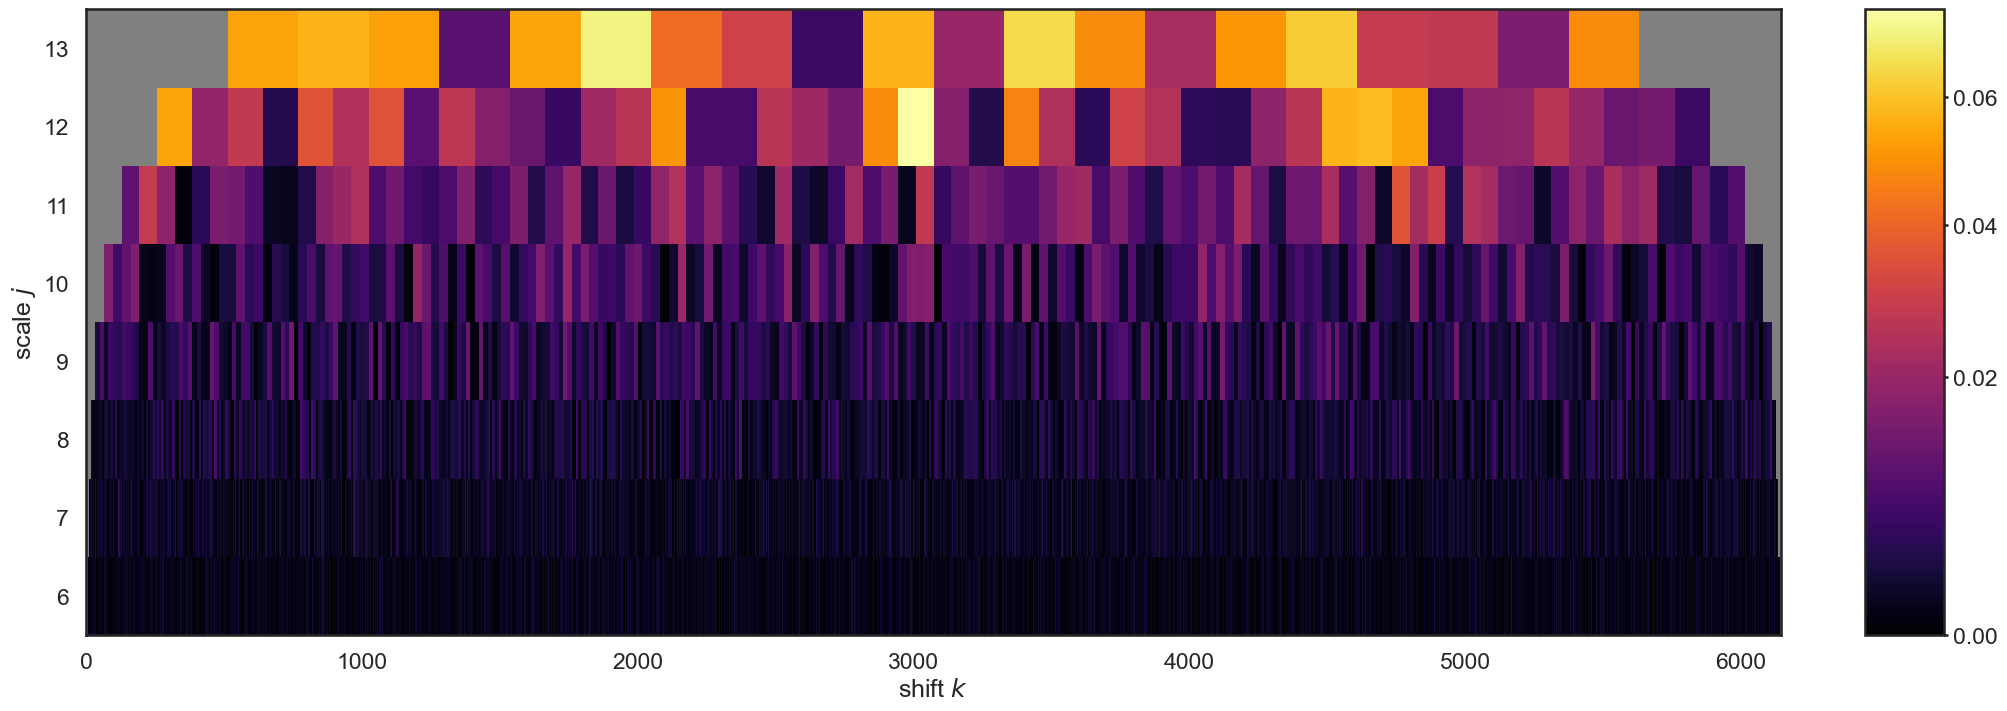

In [12]:
plot_coef(WT.wt_coefs.values, j1=6, j2=13, leader=False, vmin=0, gamma=.67)

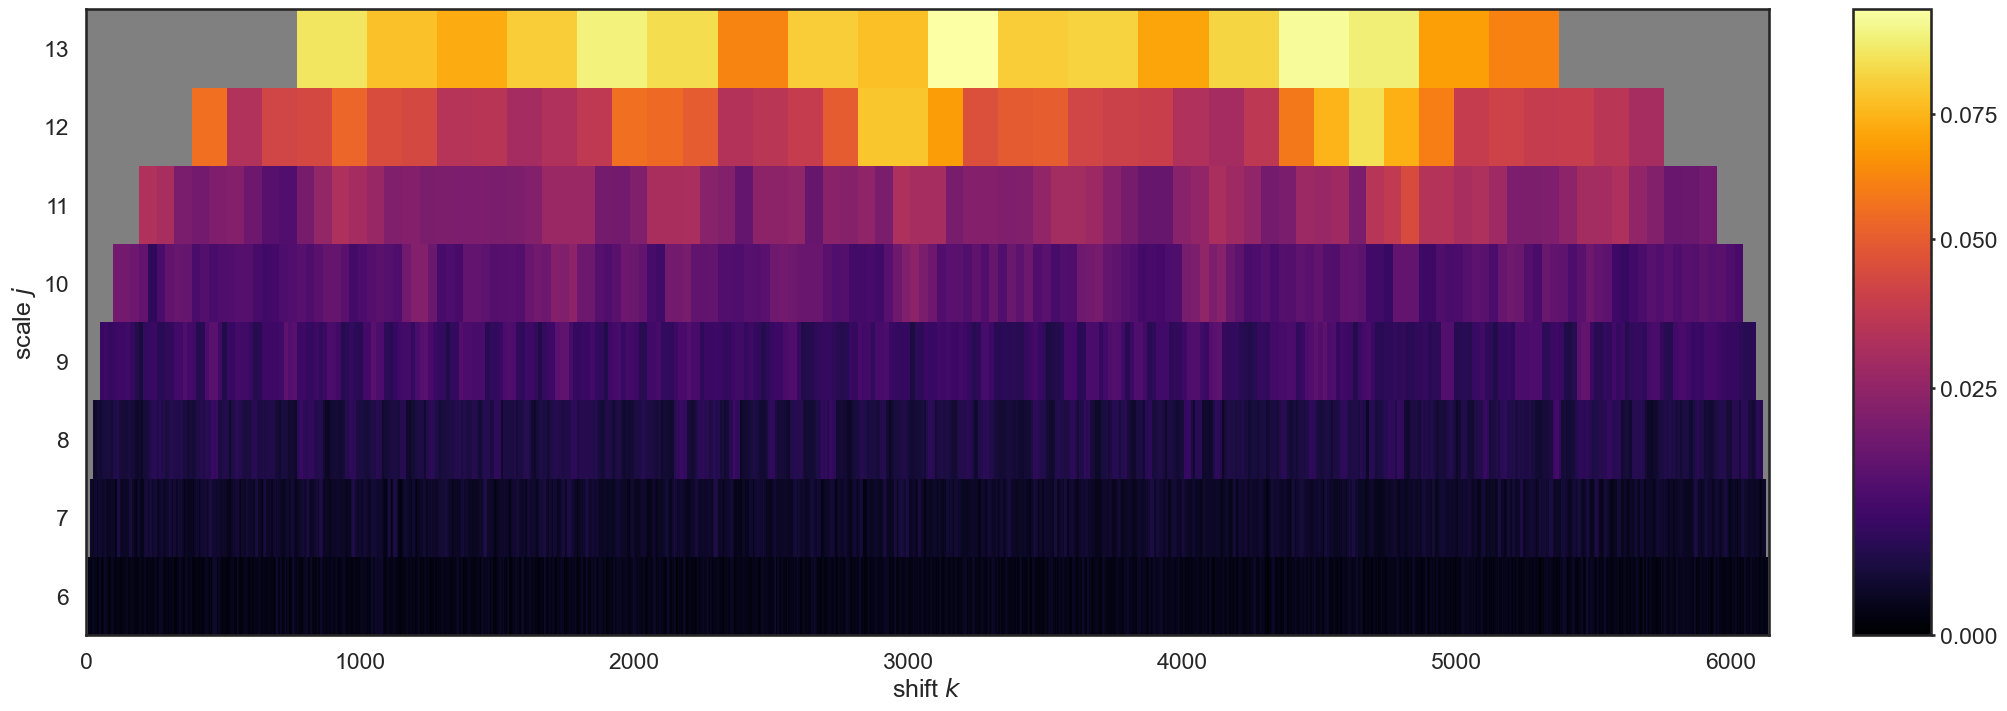

In [13]:
plot_coef(WT.wt_leaders.values, j1=6, j2=13, leader=True, gamma=.67)

### Functions for additive noise

In [7]:
rng = np.random.default_rng(seed=42)

In [8]:
from pymultifracs.simul.noisy import create_oscillation, generate_osc_freq,\
    create_mask3

#### A. Adds intermittent frequency-specific oscillation

1. Create oscillator signal w/ frequency modulation
1. Mask oscillator activity in time
1. Add on top of origin signal

In [20]:
mask = create_mask3(X_diff.shape[0], count=15, size=X_diff.shape[0] // 100,
                    align_scale=6)

freq = generate_osc_freq(X_diff.shape[0] + 10000, spread=.01, mean=.49)
osc = create_oscillation(X_diff.shape[0], freq[10000:], 1)
osc *= X_diff.std()

In [21]:
mask.sum() / mask.shape[0]

0.1499946593966644

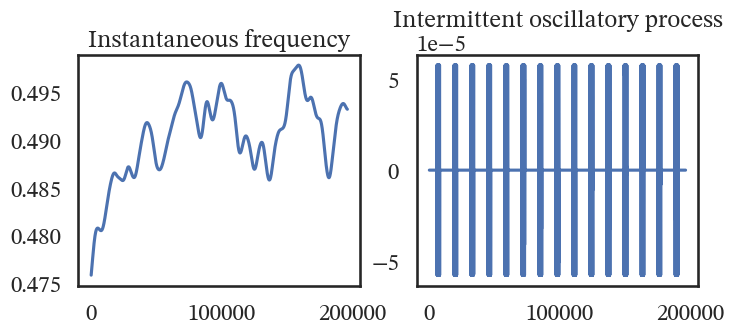

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(freq[10001:])
ax[0].set(title='Instantaneous frequency')
ax[1].plot(osc.real * mask)
ax[1].set(title='Intermittent oscillatory process')
plt.show()

In [23]:
noise = osc.real * mask * 2 ** 2
noisy_X = X_diff + noise

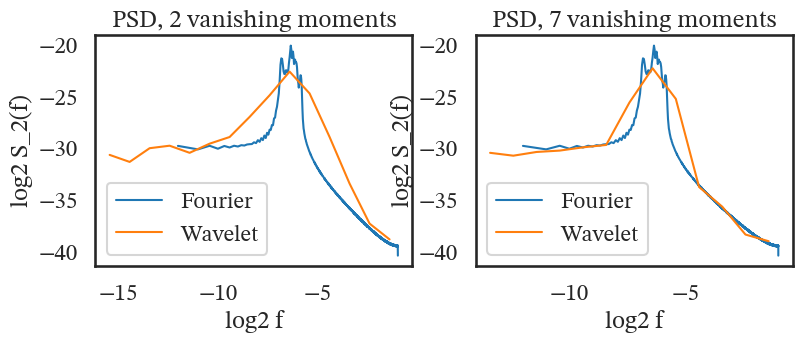

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
plot_psd(noise, 1, wt='db', n_moments=2, ax=ax[0])
ax[0].set(title='PSD, 2 vanishing moments')

plot_psd(noise, 1, wt='db', n_moments=7, ax=ax[1])
ax[1].set(title='PSD, 7 vanishing moments')

plt.show()

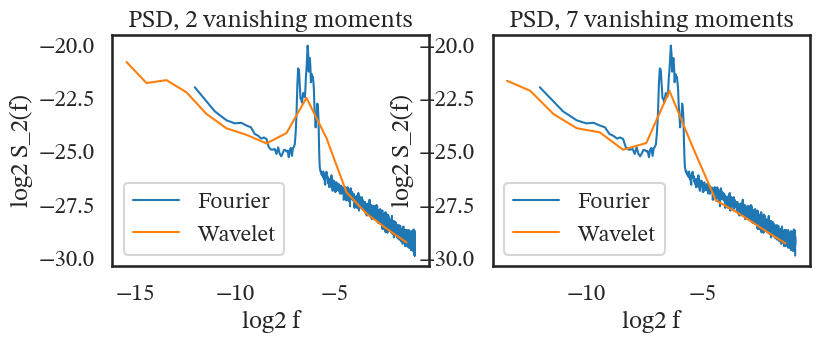

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
plot_psd(noisy_X, 1, wt='db', n_moments=2, ax=ax[0])
ax[0].set(title='PSD, 2 vanishing moments')

plot_psd(noisy_X, 1, wt='db', n_moments=7, ax=ax[1])
ax[1].set(title='PSD, 7 vanishing moments')

plt.show()

In [26]:
WT = wavelet_analysis(noisy_X, p_exp=2, j1=8, j2_reg=14, gamint=1)

In [27]:
dwt, lwt = mf_analysis([WT.wt_coefs, WT.wt_leaders], scaling_ranges=[(8, WT.wt_leaders.j2_eff())])

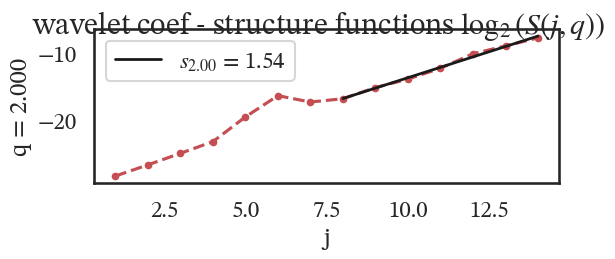

In [28]:
dwt.structure.plot(figsize=(6, 2))

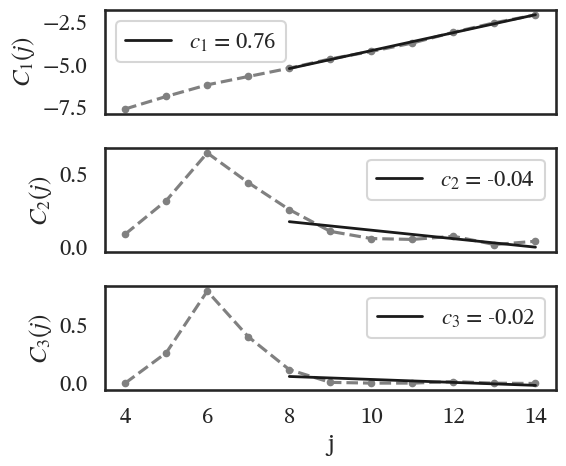

In [29]:
lwt.cumulants.plot(j1=4, figsize=(6, 5))

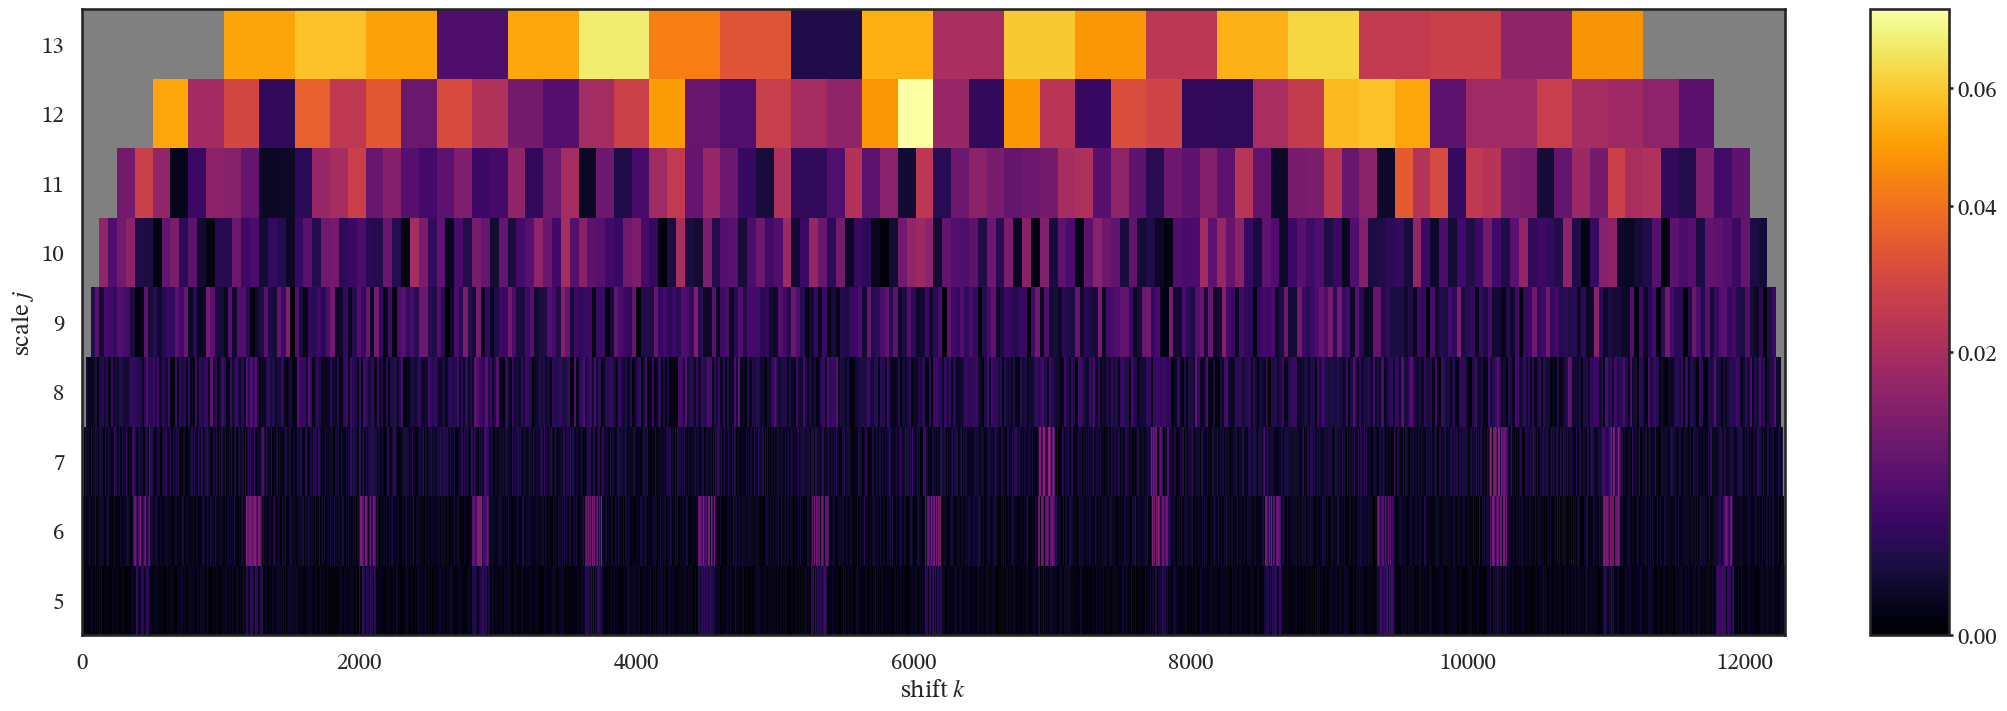

In [30]:
plot_coef(WT.wt_coefs.values, j1=5, j2=13, leader=False, vmin=0, gamma=.6)

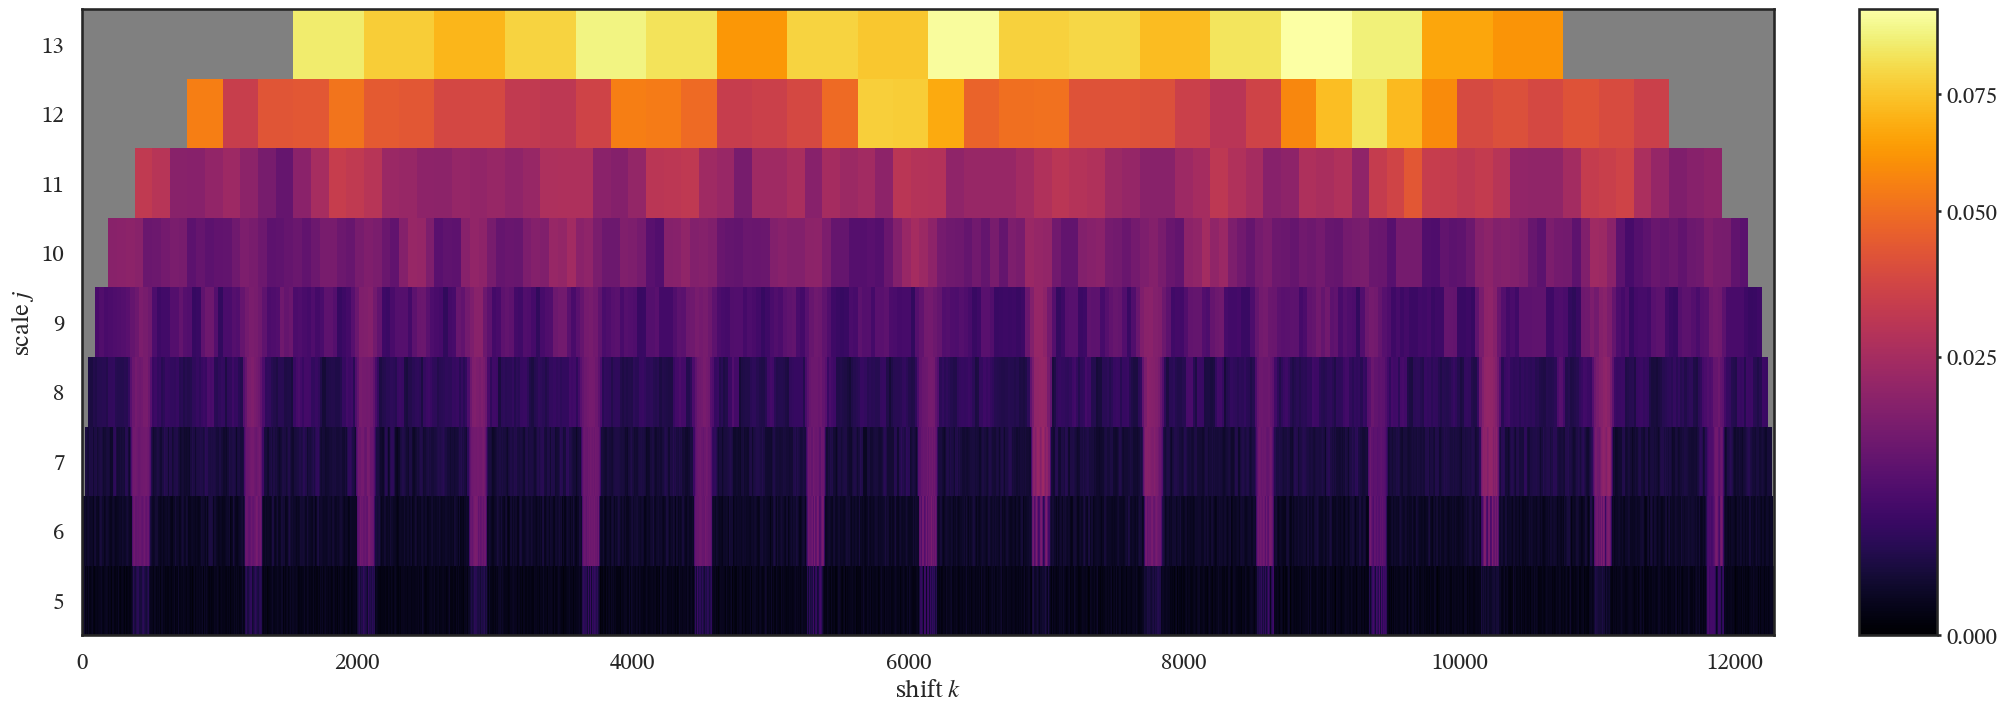

In [31]:
plot_coef(WT.wt_leaders.values, j1=5, j2=13, leader=True, gamma=.6)

#### B. Adds intermittent, broadband (including low-freq) noise

In [9]:
mask = create_mask3(X_diff.shape[0], 3, (N + 1) // 100, 12)

In [10]:
mask.sum() / mask.shape[0]

0.029998931879332884

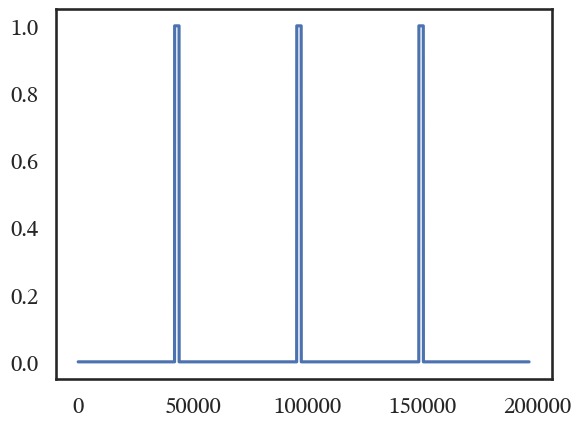

In [11]:
plt.plot(mask)

In [12]:
noise = fbm(shape=X.shape[0], H=.9)
noise = mask * np.diff(noise)

In [13]:
noisy_X = 25 * noise + X_mrw_diff

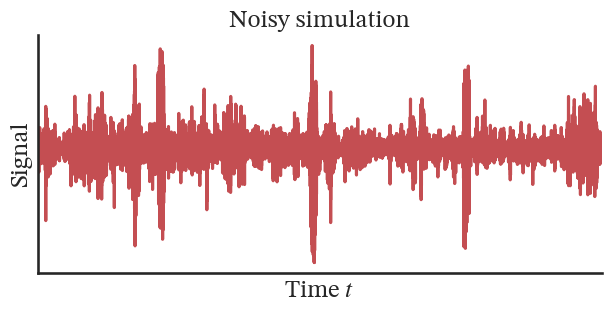

In [14]:
plt.figure(figsize=(6, 3), layout='constrained')
plt.plot(noisy_X, c='C3')
plt.gca().set(xlabel='Time $t$', ylabel='Signal', xticks=[], yticks=[], title='Noisy simulation',
              xlim=(0, X_diff.shape[0]))
sns.despine()
plt.savefig(figure_folder / 'noisy.png', dpi=600)

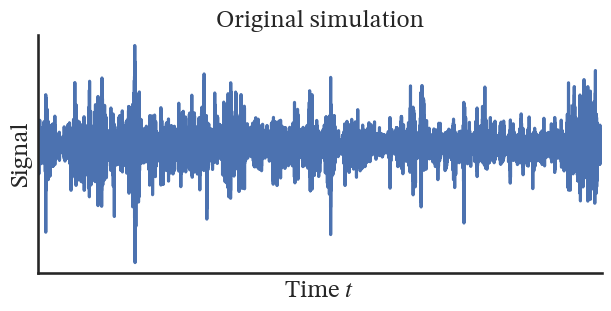

In [15]:
plt.figure(figsize=(6, 3), layout='constrained')
plt.plot(X_mrw_diff, c='C0')
plt.gca().set(xlabel='Time $t$', ylabel='Signal', xticks=[], yticks=[], title='Original simulation',
              xlim=(0, X_diff.shape[0]))
sns.despine()
plt.savefig(figure_folder / 'original.png', dpi=600)

In [16]:
WT = wavelet_analysis(noisy_X, p_exp=2, j1=8, j2_reg=13, gamint=1)
WT_orig = wavelet_analysis(X_mrw_diff, p_exp=2, j1=8, j2_reg=13, gamint=1)

In [17]:
lwt = mf_analysis([WT.wt_leaders], scaling_ranges=[(8, 13)], n_cumul=2)[0]
lwt_orig = mf_analysis([WT_orig.wt_leaders], scaling_ranges=[(8, 13)], n_cumul=2)[0]

In [31]:
sns.set_context('talk')
mpl.rcParams['figure.dpi'] = 600

[Text(0.5, 1.0, 'Original simulation')]

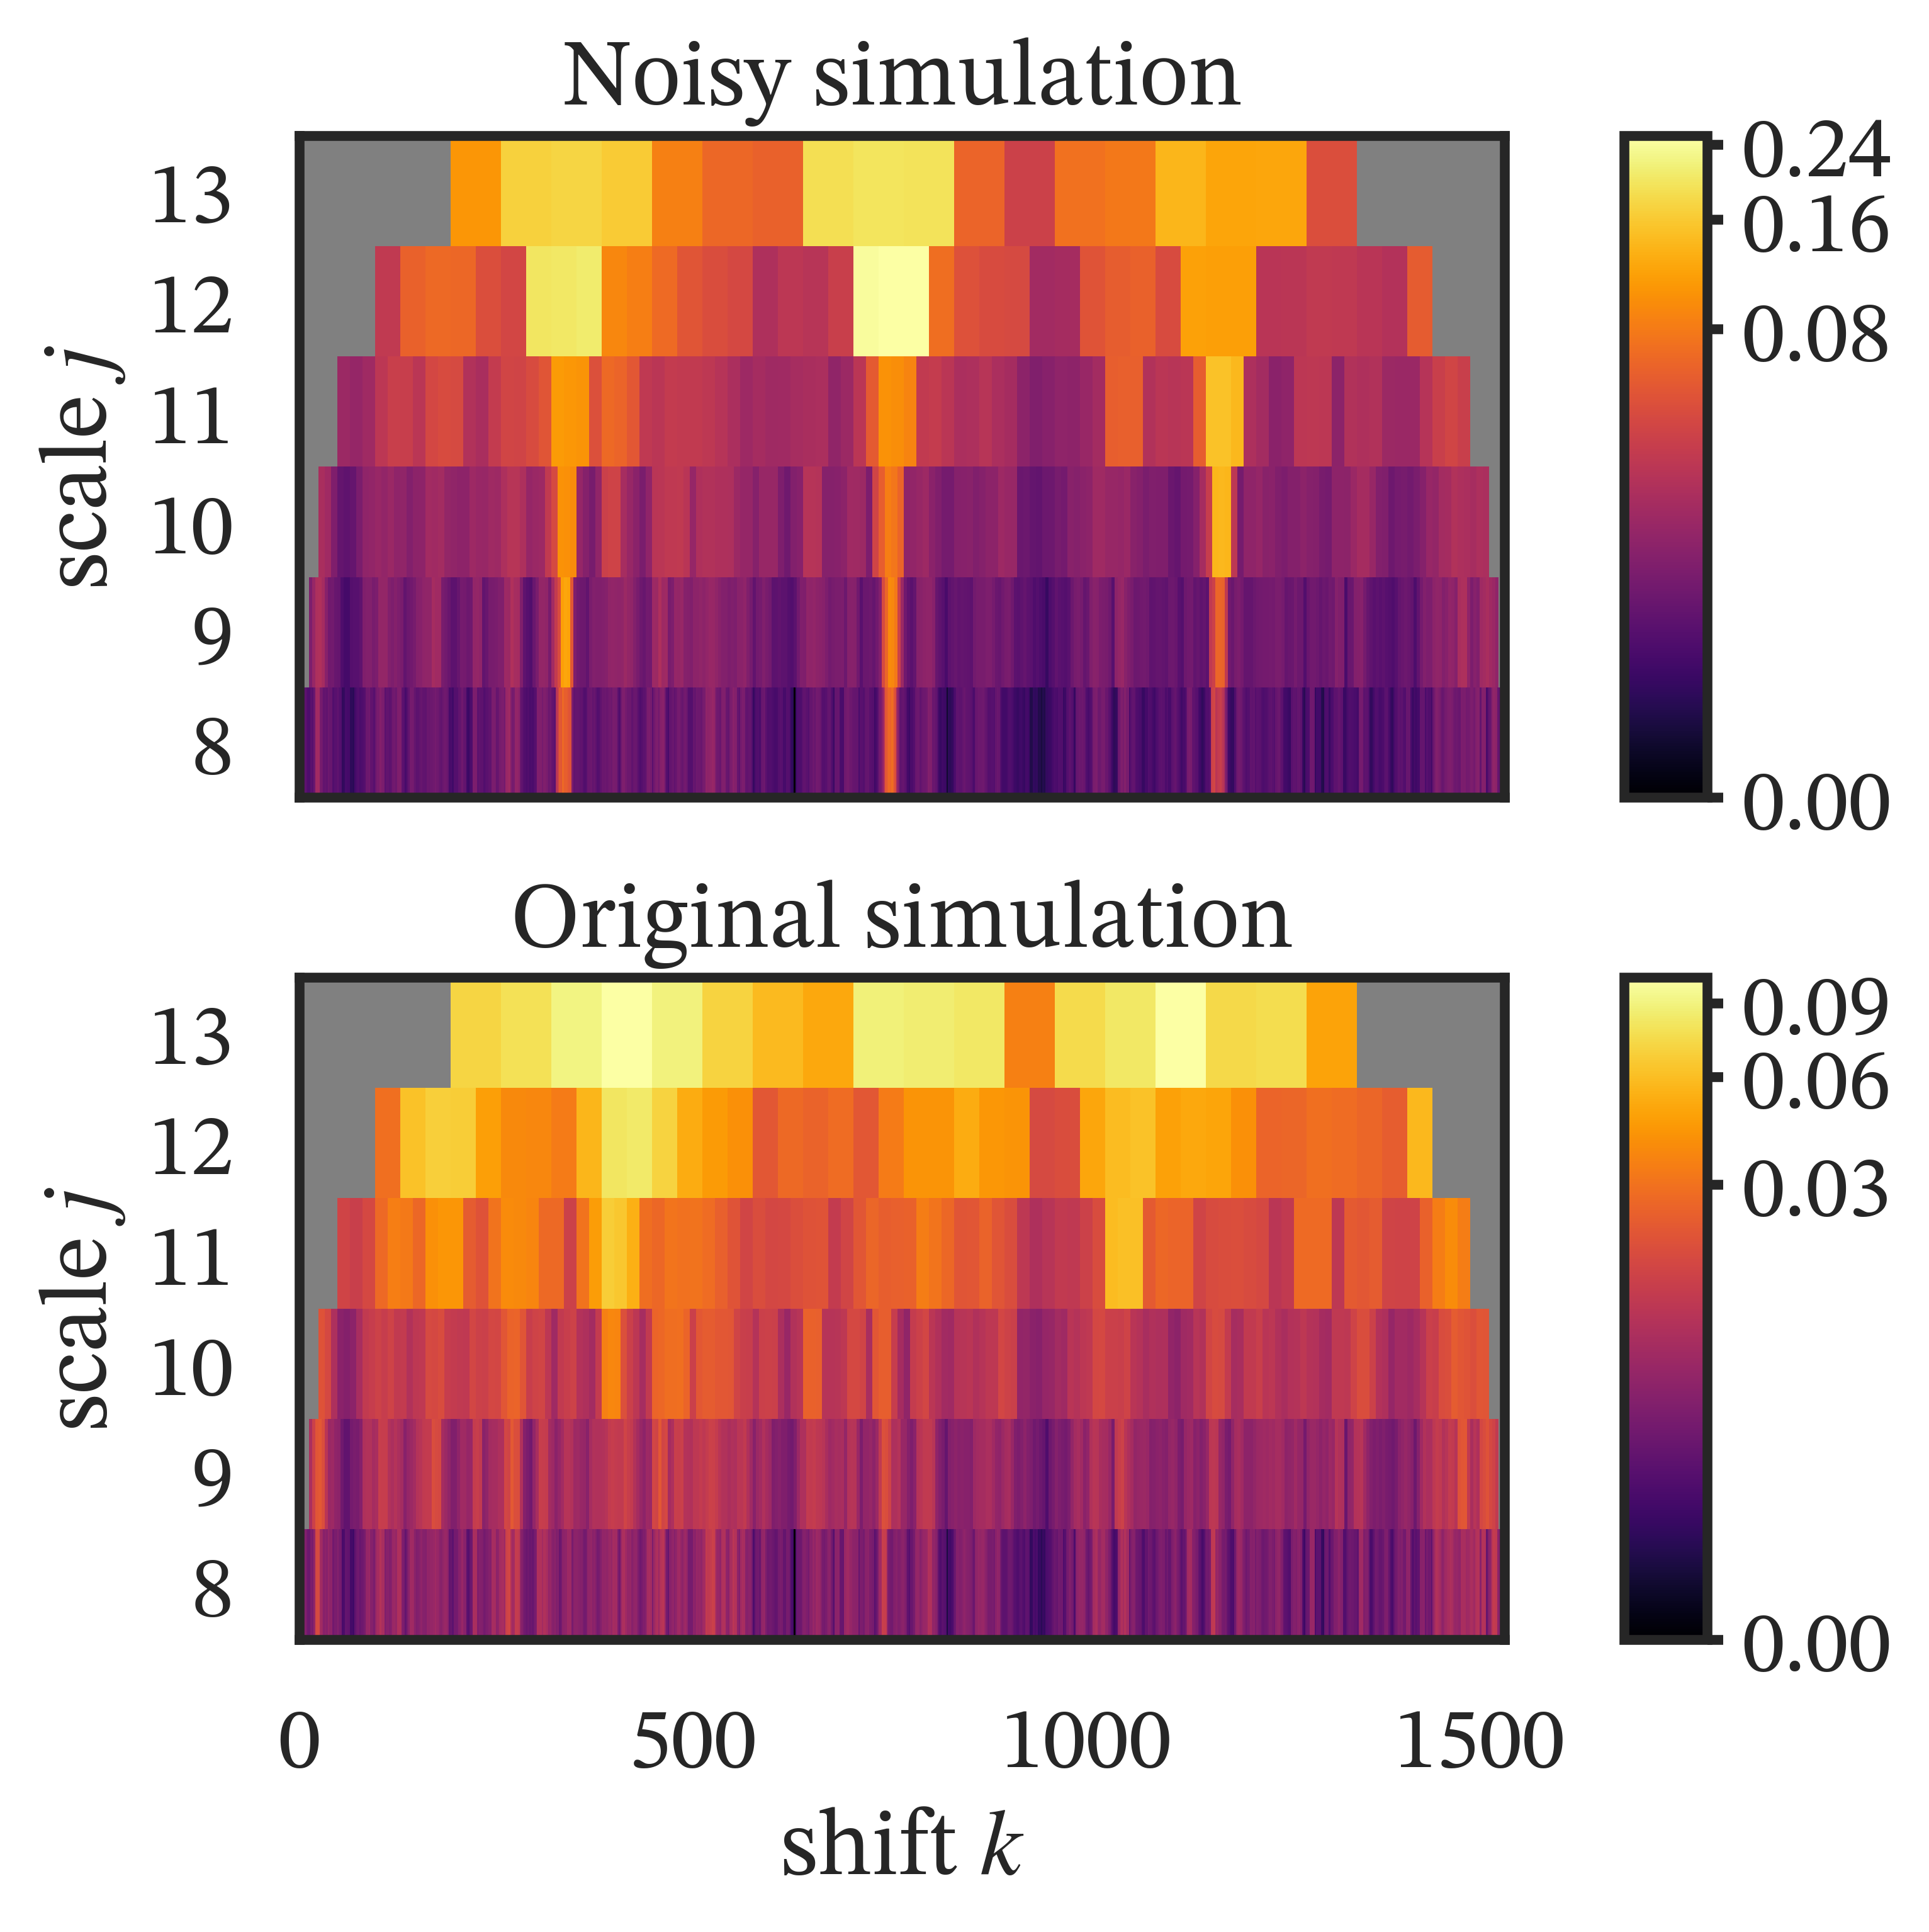

In [37]:
fig, axes = plt.subplots(2, 1, layout='constrained', sharex=True, figsize=(5, 5))

plot_coef(WT.wt_leaders.values, j1=8, j2=13, ax=axes[0])
plot_coef(WT_orig.wt_leaders.values, j1=8, j2=13, ax=axes[1])
axes[0].set(xlabel='', title='Noisy simulation')
axes[1].set(title='Original simulation')

In [18]:
from pymultifracs.viz import plot_cm

In [19]:
def get_palette_from_color(color, as_cmap=True, n_colors=5):

    color_rgb = mpl.colors.colorConverter.to_rgb(color)
    colors = [sns.utils.set_hls_values(color_rgb, l=l)  # noqa
                for l in np.linspace(1, 0, 12)]
    return sns.blend_palette(colors, as_cmap=as_cmap, n_colors=n_colors)

In [20]:
C1_color = get_palette_from_color('C0')(.4)
C2_color = get_palette_from_color('C1')(.4)
C_noisy_color = get_palette_from_color('C3')(.45)

c1_color = get_palette_from_color('C0')(.6)
c2_color = get_palette_from_color('C1')(.6)
c_noisy_color = get_palette_from_color('C3')(.6)

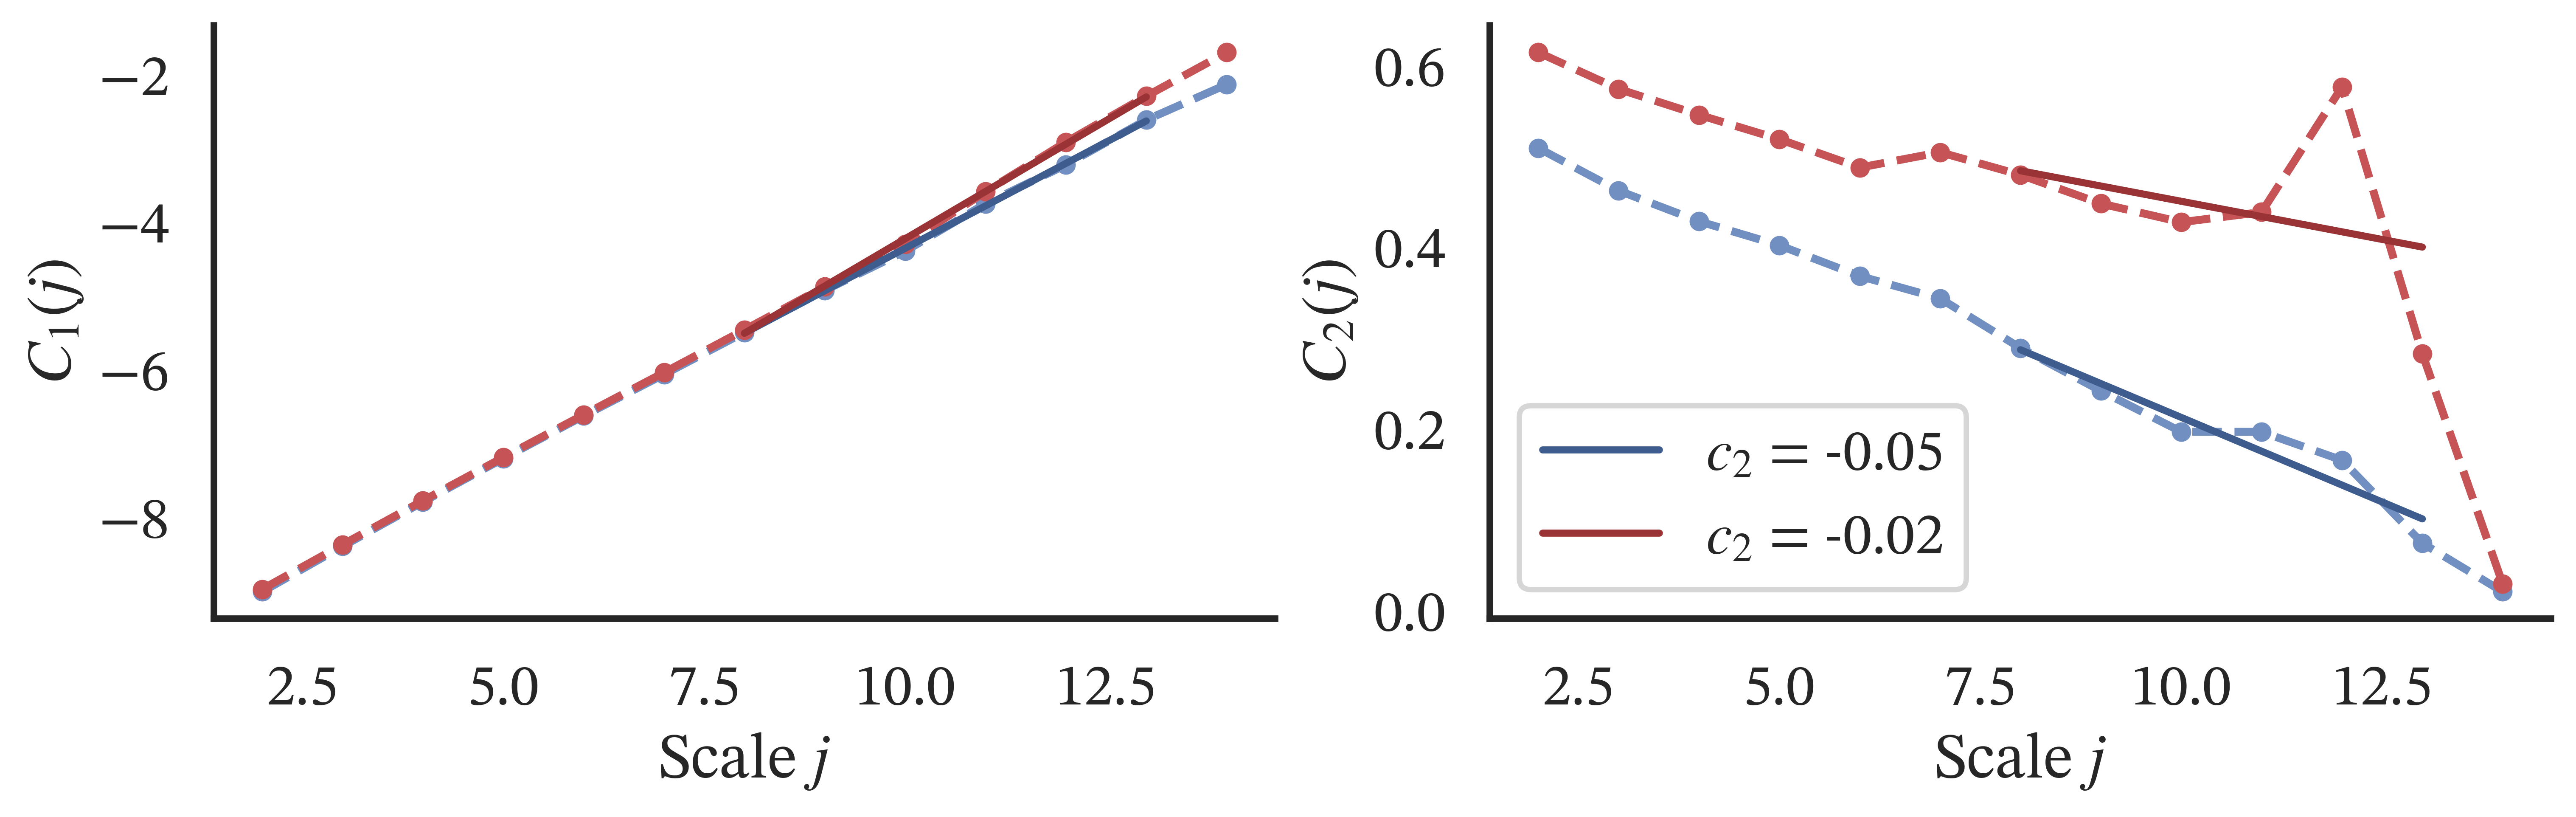

In [38]:
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(10, 5 / 1.618))

plot_cm(lwt_orig.cumulants, 0, 2, 14, scaling_range=0, ax=ax[0], C_color=C1_color, fit_color=c1_color)
plot_cm(lwt.cumulants, 0, 2, 14, scaling_range=0, ax=ax[0], C_color=C_noisy_color, fit_color=c_noisy_color)
plot_cm(lwt_orig.cumulants, 1, 2, 14, scaling_range=0, ax=ax[1], C_color=C1_color, fit_color=c1_color)
plot_cm(lwt.cumulants, 1, 2, 14, scaling_range=0, ax=ax[1], C_color=C_noisy_color, fit_color=c_noisy_color)

ax[1].legend()

ax[0].set(xlabel='Scale $j$')
ax[1].set(xlabel='Scale $j$')

sns.despine()
fig.savefig(figure_folder / 'C.png', dpi=600)

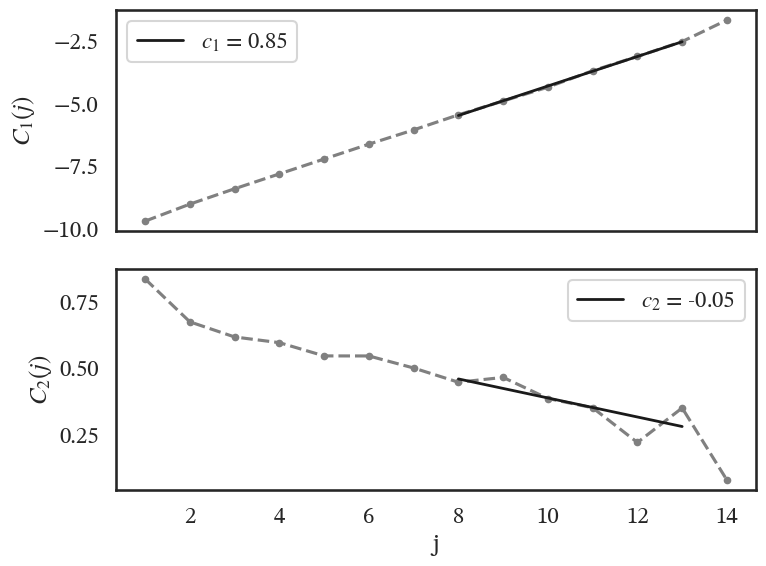

In [96]:
lwt_orig.cumulants.plot()

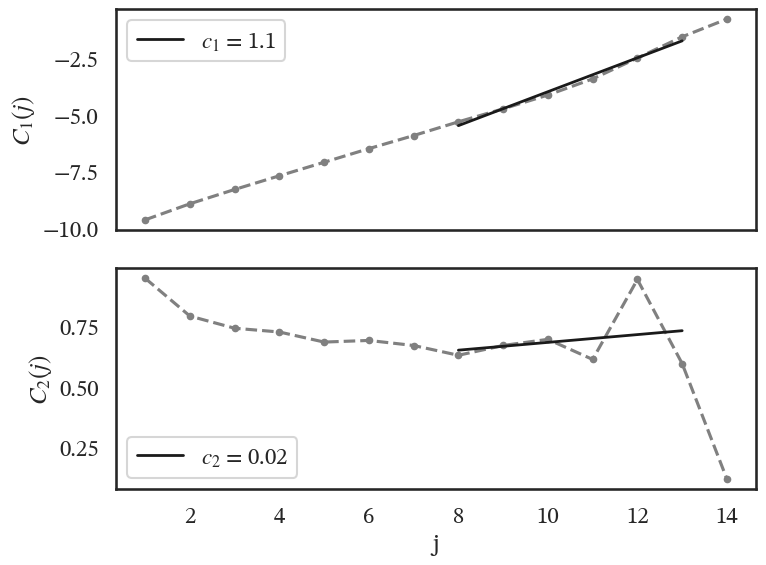

In [97]:
lwt.cumulants.plot()

In [52]:
durations = 1e3

[(-42.4555077580128, -27.243742317044546),
 Text(0.5, 1.0, 'PSD, 7 vanishing moments')]

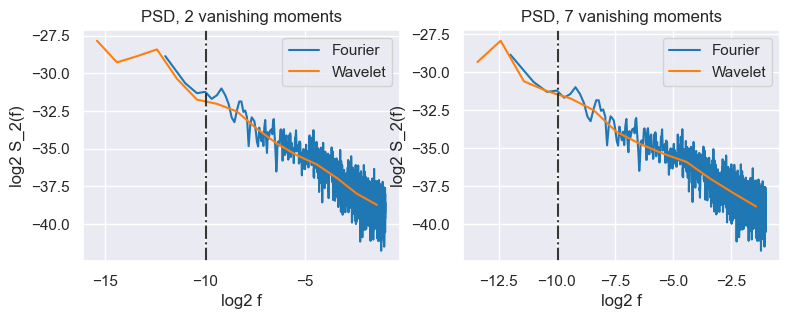

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
plot_psd(noise, 1, wt='db', n_moments=2, ax=ax[0])
ylim = ax[0].get_ylim()
ax[0].vlines(-np.log2(durations), *ylim, colors='xkcd:dark grey', linestyles='-.')
ax[0].set(ylim=ylim, title='PSD, 2 vanishing moments')

plot_psd(noise, 1, wt='db', n_moments=7, ax=ax[1])
ylim = ax[1].get_ylim()
ax[1].vlines(-np.log2(durations), *ylim, colors='xkcd:dark grey', linestyles='-.')
ax[1].set(ylim=ylim, title='PSD, 7 vanishing moments')

[Text(0.5, 1.0, 'PSD, 7 vanishing moments')]

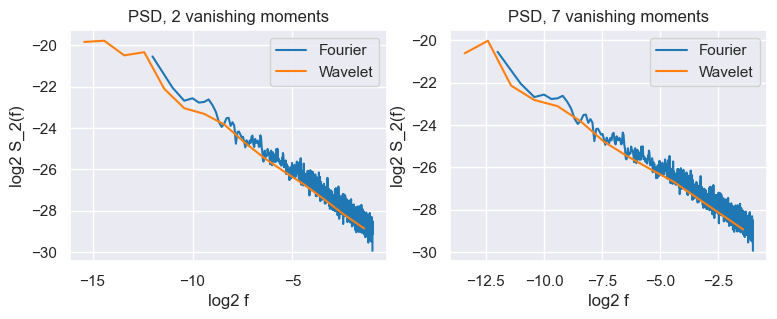

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
plot_psd(noisy_X, 1, wt='db', n_moments=2, ax=ax[0])
ax[0].set(title='PSD, 2 vanishing moments')

plot_psd(noisy_X, 1, wt='db', n_moments=7, ax=ax[1])
ax[1].set(title='PSD, 7 vanishing moments')

In [123]:
WT = wavelet_analysis(noisy_X, p_exp=2, j1=8, j2_reg=14, gamint=1)

In [124]:
dwt, lwt = mf_analysis([WT.wt_coefs, WT.wt_leaders], scaling_ranges=[(8, WT.wt_leaders.j2_eff() - 2)])

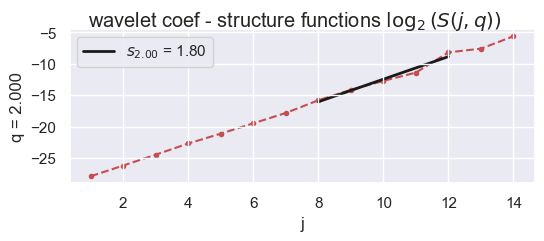

In [125]:
dwt.structure.plot(figsize=(6, 2))

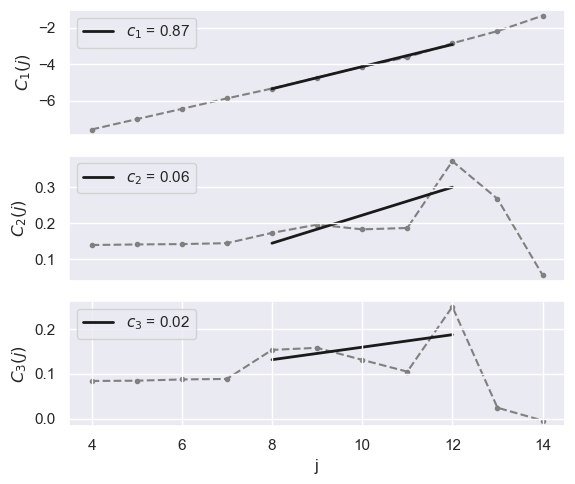

In [126]:
lwt.cumulants.plot(j1=4, figsize=(6, 5))

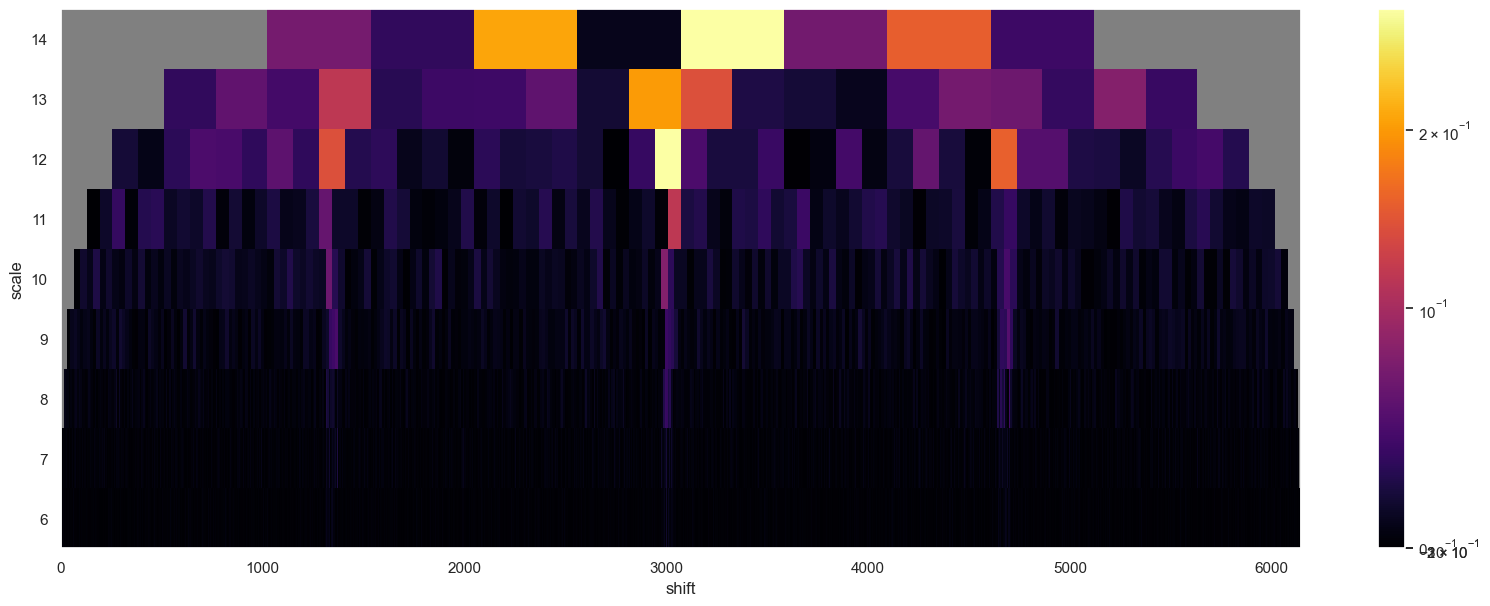

In [127]:
plot_coef(WT.wt_coefs.values, j1=6, j2=14, leader=False, vmin=0, gamma=.8)

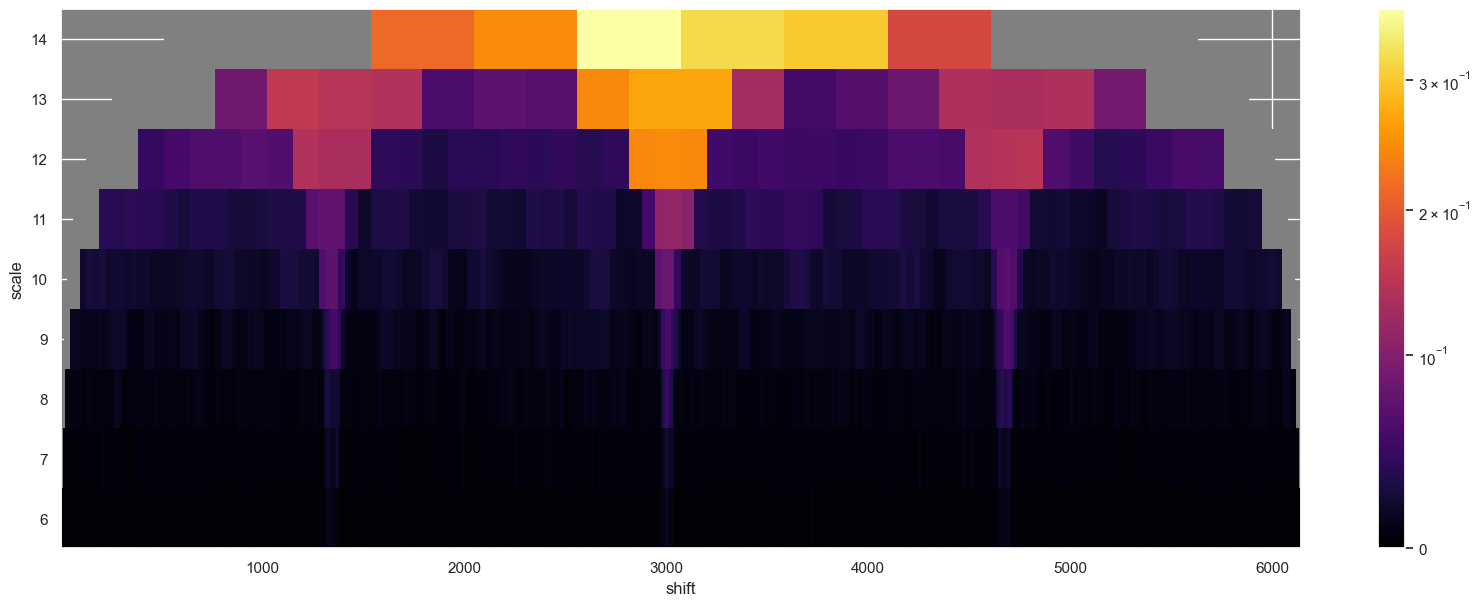

In [128]:
plot_coef(WT.wt_leaders.values, j1=6, j2=14, leader=True, gamma=.8)

### Impact on coeffs

In [130]:
from pymultifracs.utils import scale_position

In [131]:
wt_idx, leader_idx = scale_position(np.arange(X_diff.shape[0])[mask], 5, 13,
                                    wt_leaders=WT.wt_leaders)

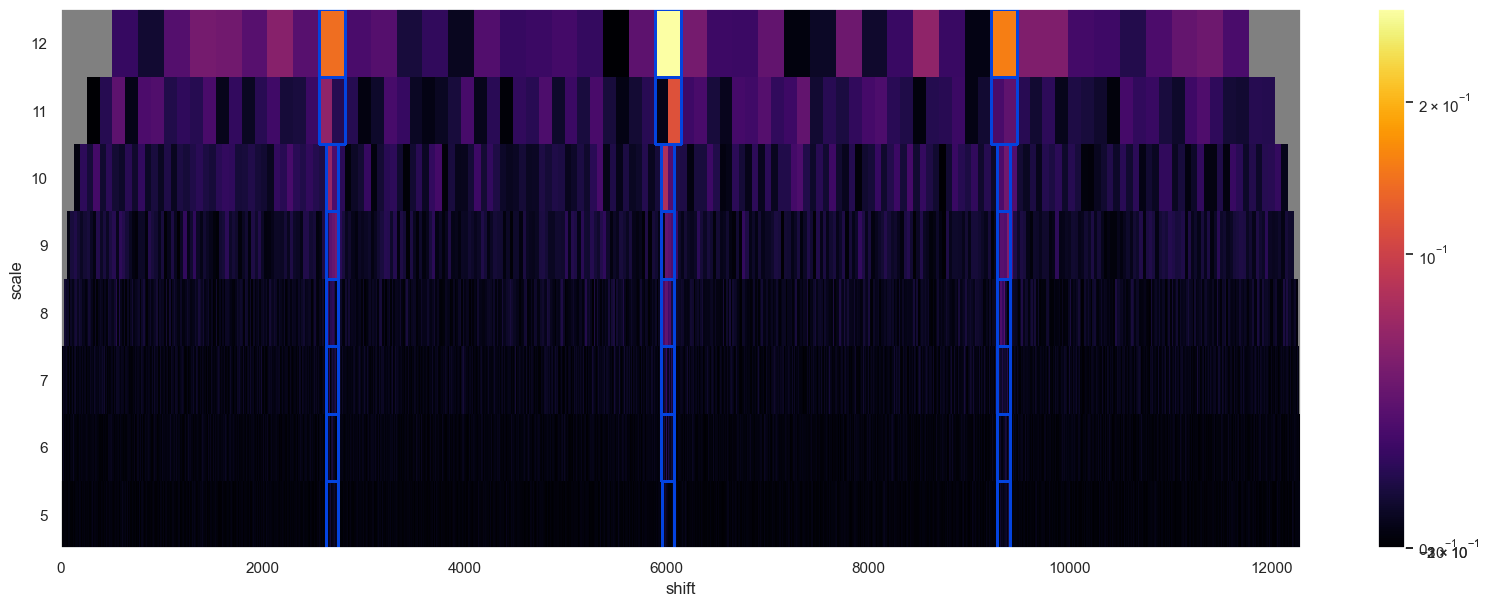

In [137]:
plot_coef(WT.wt_coefs.values, j1=5, j2=12, leader=False, vmin=0, gamma=.6, nan_idx=wt_idx)

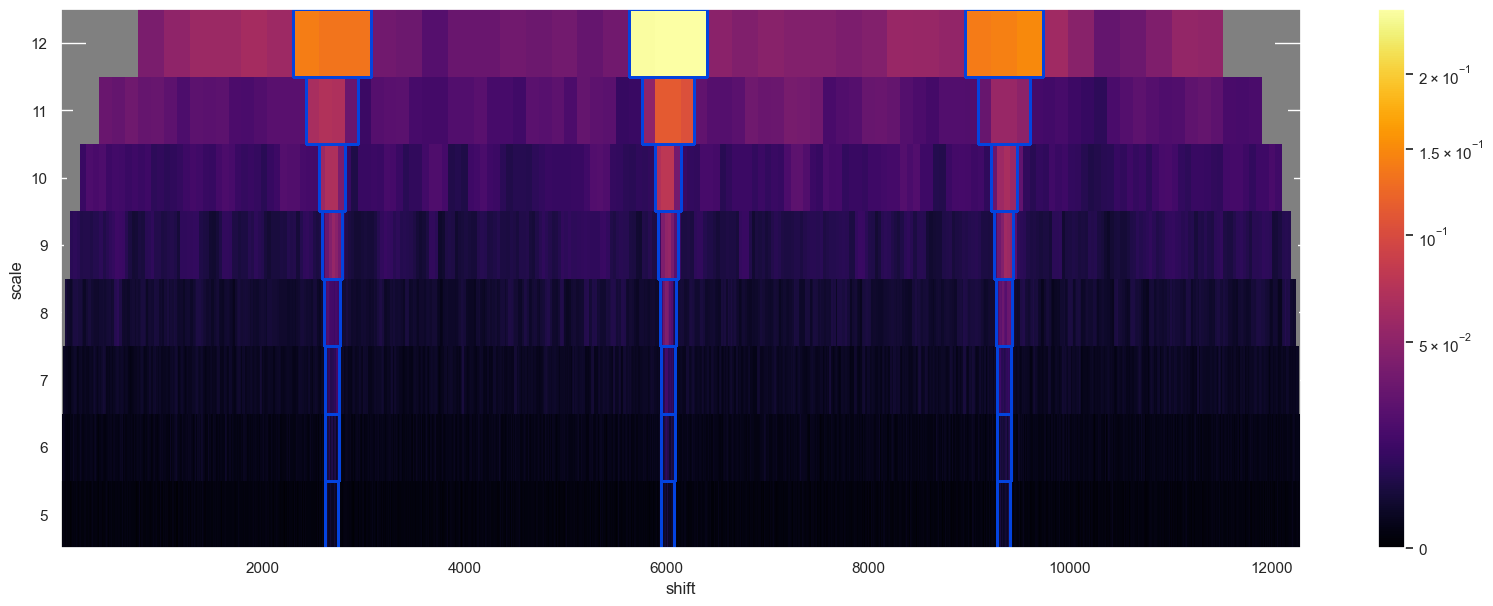

In [138]:
plot_coef(WT.wt_leaders.values, j1=5, j2=12, leader=True, gamma=.6, nan_idx=leader_idx)

## Results on multiple runs

In [139]:
from pymultifracs.simul.noisy import create_mask3, gen_estimate, \
    generate_simuls, generate_simuls_bb

### Oscillatory noise

In [389]:
covgrid = np.arange(101)
SNRgrid = np.r_[0, np.geomspace(1, 15, 10)[1:]]

df_osc = gen_estimate(N, generate_simuls, SNRgrid, covgrid, n_rep=40,
                      n_jobs=15, align_scale=6)

77234.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
77234.79s - pydevd: Sending message rela

14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
1414

14
14
14
14
14
14
14
14
1

In [399]:
delta = np.diff(np.log(SNRgrid[1:]))[0]
SNRgrid_plot = SNRgrid.copy()
SNRgrid_plot[0] = np.e ** (np.log(SNRgrid[1]) - delta)

In [400]:
df_consistency = df_osc.copy()

for rep in df_osc.index.get_level_values(level=0):
        for c in 'c1 c2 c3'.split(' '):
            df_consistency.loc[rep, c] = (df_consistency.loc[rep, c] - df_consistency.loc[(rep, 0), (c, 0)]).values

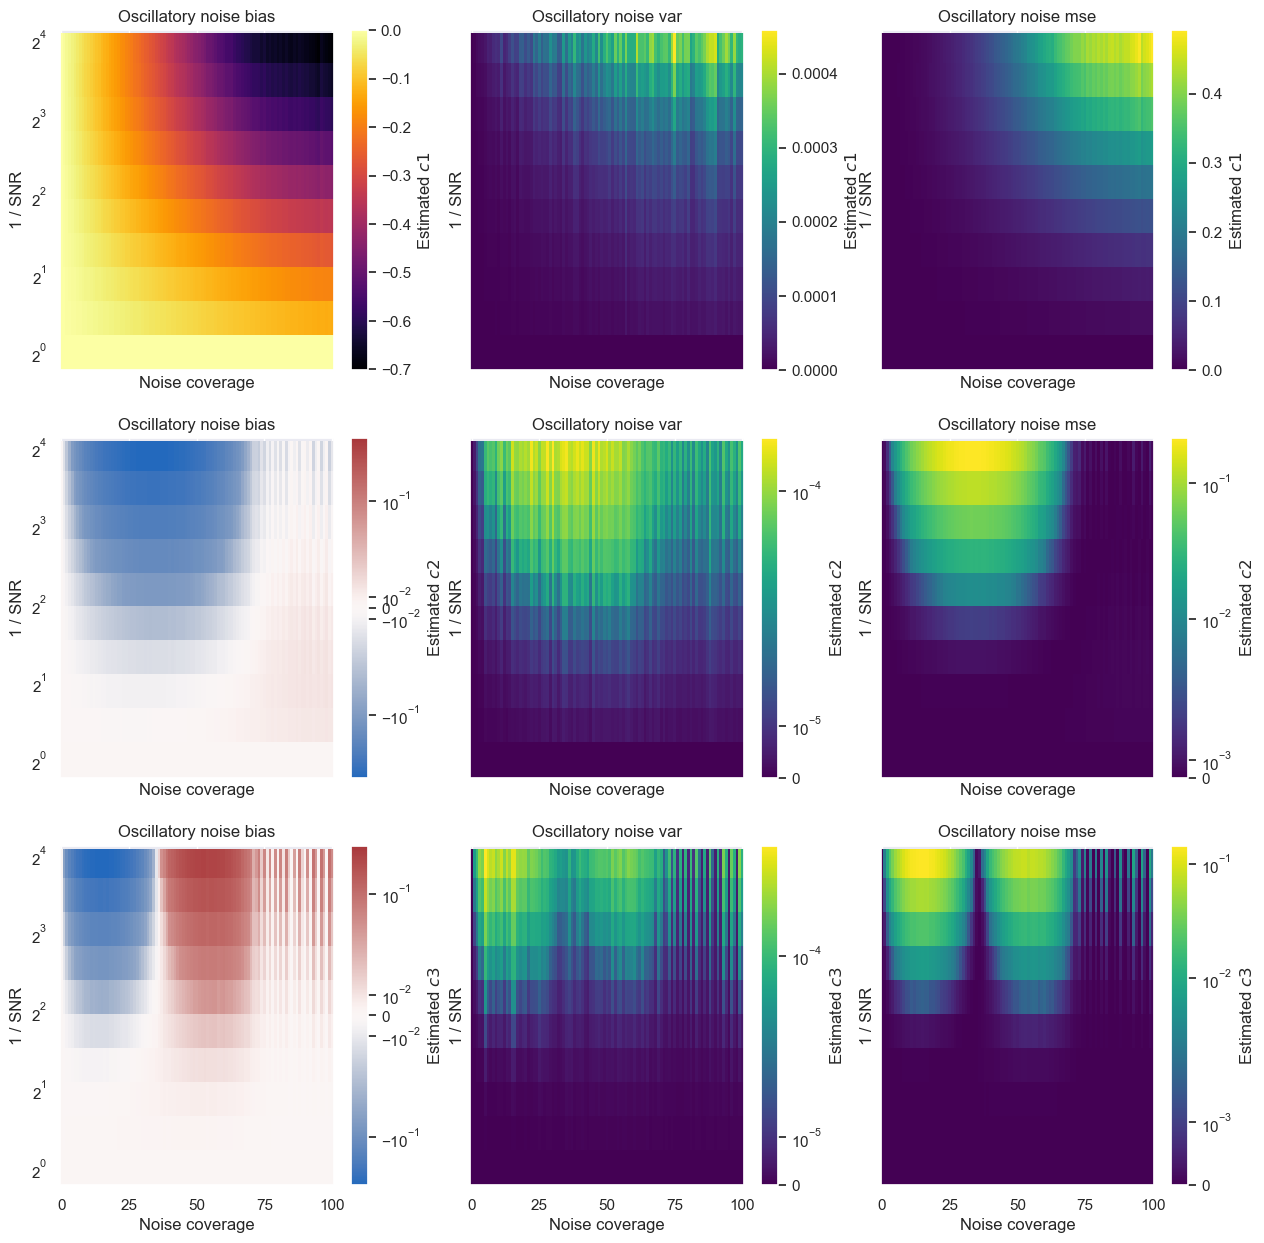

In [ ]:
_, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for i, var in enumerate('c1 c2 c3'.split(' ')):
    for j, stat in enumerate('bias var mse'.split(' ')):
        plot_map(covgrid, SNRgrid_plot, df_consistency, var, stat, ax=ax[i, j])

plt.show()

#### Theoretical

In [401]:
df_theoretical = df_osc.copy()

df_theoretical.c1 -= .8

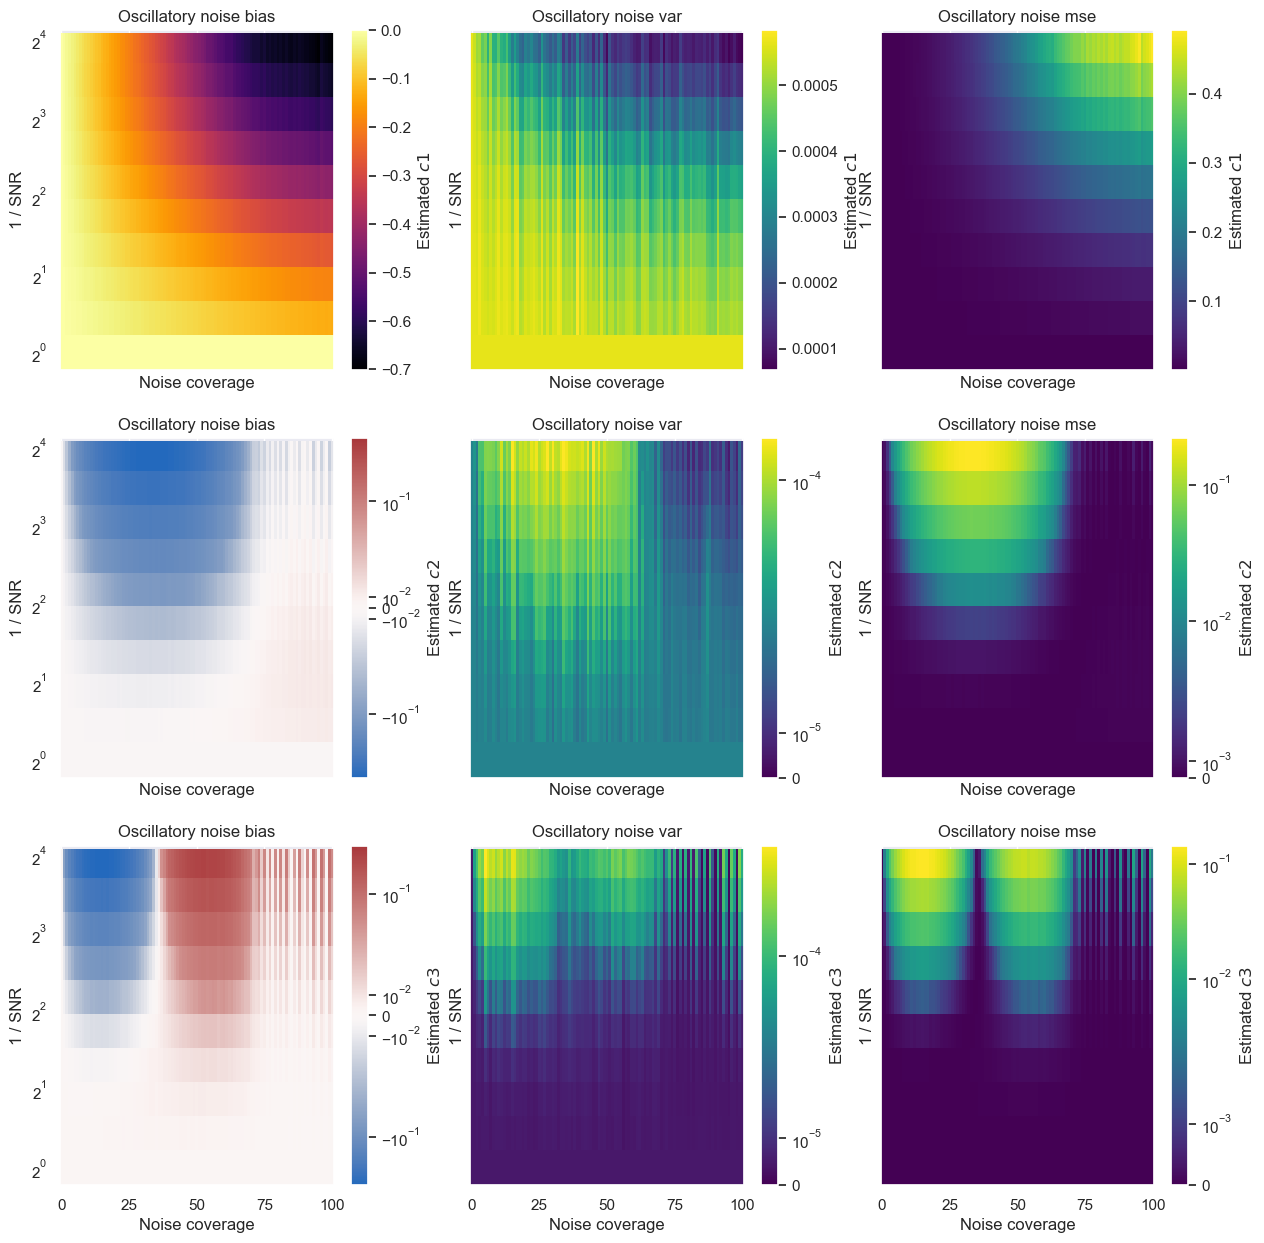

In [ ]:
_, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for i, var in enumerate('c1 c2 c3'.split(' ')):
    for j, stat in enumerate('bias var mse'.split(' ')):
        plot_map(covgrid, SNRgrid_plot, df_theoretical, var, stat, ax=ax[i, j])

plt.show()

### Broadband noise

In [146]:
SNRgrid = np.r_[0, np.geomspace(1, 15, 10)[1:]]
covgrid = np.arange(14)

df_bb = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40, n_jobs=14, align_scale=12)

In [147]:
delta = np.diff(np.log(SNRgrid[1:]))[0]
SNRgrid_plot = SNRgrid.copy()
SNRgrid_plot[0] = np.e ** (np.log(SNRgrid[1]) - delta)

#### Consistency

In [148]:
df_consistency = df_bb.copy()

for rep in df_bb.index.get_level_values(level=0):
        for c in 'c1 c2 c3'.split(' '):
            df_consistency.loc[rep, c] = (df_consistency.loc[rep, c] - df_consistency.loc[(rep, 0), (c, 0)]).values

#### Theoretical

In [149]:
df_theoretical = df_bb.copy()

df_theoretical.c1 -= .8

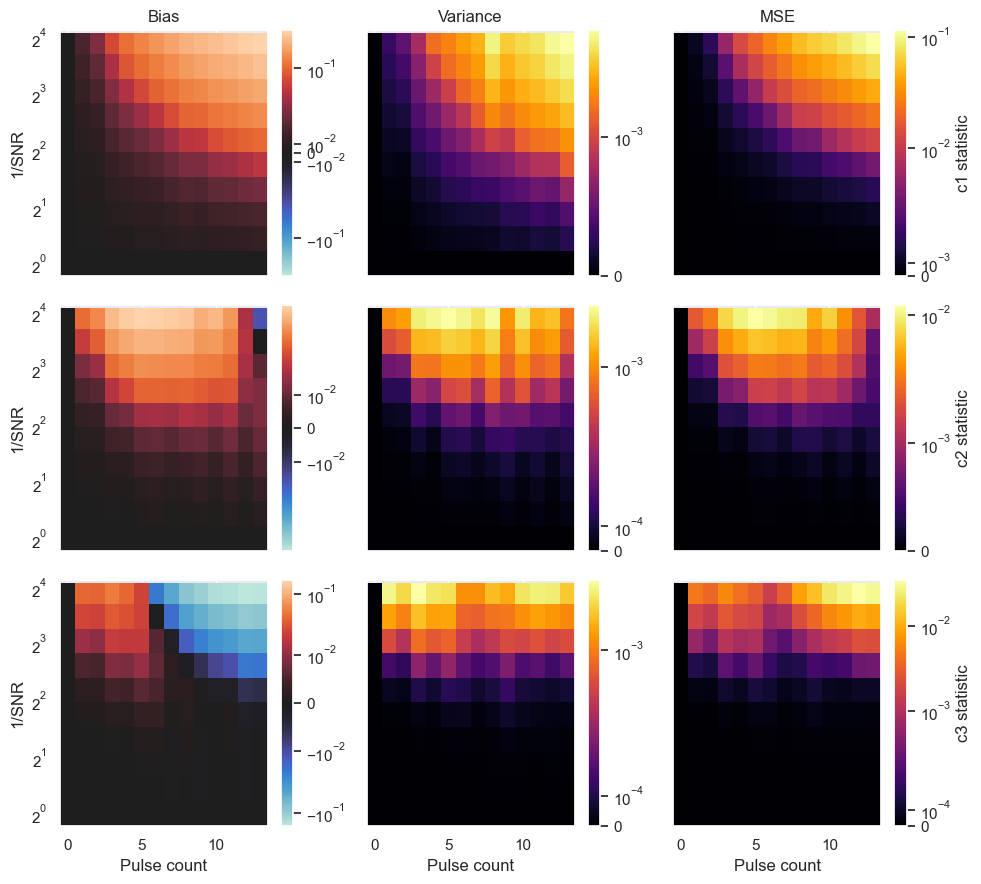

In [175]:
_, ax = plt.subplots(3, 3, figsize=(10, 9), sharex=True, sharey=True)

for i, var in enumerate('c1 c2 c3'.split(' ')):
    for j, stat in enumerate('bias var mse'.split(' ')):

        cbar_label = None

        if j == 2:
            cbar_label = '{var} statistic'

        plot_map(covgrid, SNRgrid_plot, df_consistency, var, stat, ax=ax[i, j],
                 cbar_label=cbar_label)

ax[0, 0].set(title='Bias', ylabel='1/SNR')
ax[1, 0].set(ylabel='1/SNR')
ax[2, 0].set(ylabel='1/SNR', xlabel='Pulse count')
ax[0, 1].set(title='Variance')
ax[0, 2].set(title='MSE')
ax[2, 1].set(xlabel='Pulse count')
ax[2, 2].set(xlabel='Pulse count')

plt.tight_layout()

plt.show()

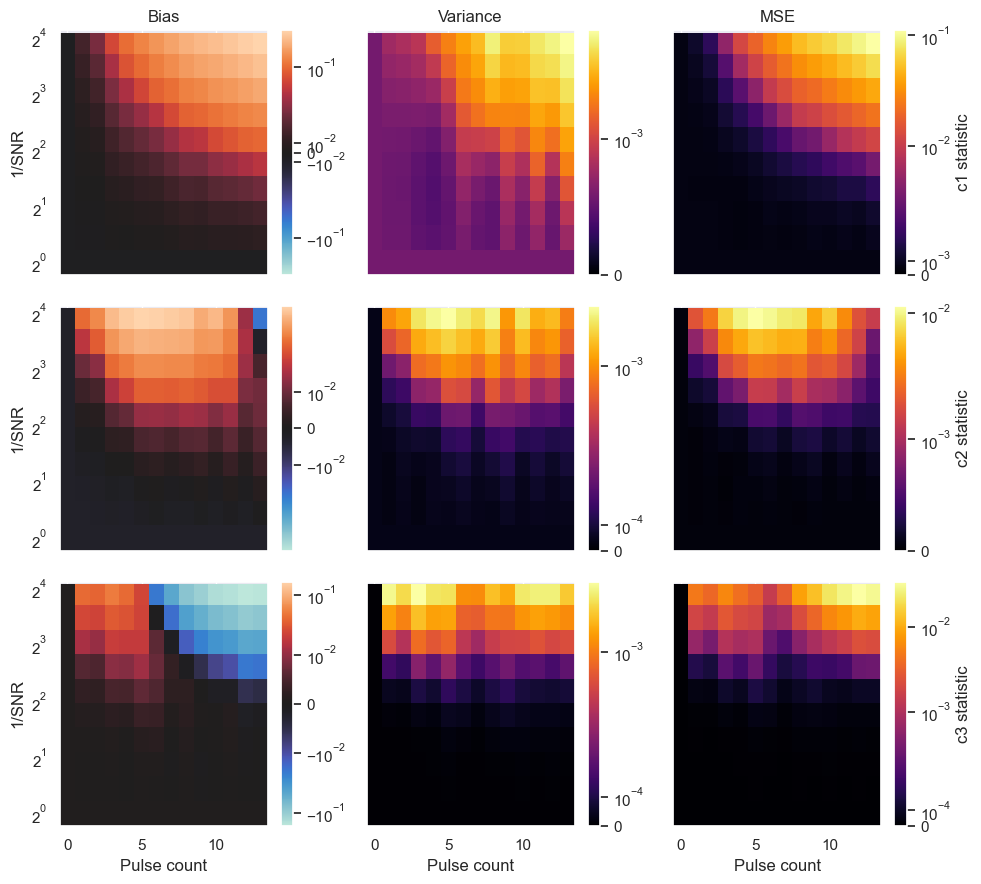

In [176]:
_, ax = plt.subplots(3, 3, figsize=(10, 9), sharex=True, sharey=True)

for i, var in enumerate('c1 c2 c3'.split(' ')):
    for j, stat in enumerate('bias var mse'.split(' ')):

        cbar_label = None

        if j == 2:
            cbar_label = '{var} statistic'

        plot_map(covgrid, SNRgrid_plot, df_theoretical, var, stat, ax=ax[i, j],
                 cbar_label=cbar_label)

ax[0, 0].set(title='Bias', ylabel='1/SNR')
ax[1, 0].set(ylabel='1/SNR')
ax[2, 0].set(ylabel='1/SNR', xlabel='Pulse count')
ax[0, 1].set(title='Variance')
ax[0, 2].set(title='MSE')
ax[2, 1].set(xlabel='Pulse count')
ax[2, 2].set(xlabel='Pulse count')

plt.tight_layout()

plt.show()

In [171]:
def plot_map(covgrid, SNRgrid, df, var, stat, ax=None,
             cbar_label=None):

    if stat in ['var', 'mse'] and len(df.index.get_level_values(0).unique()) == 1:
        return

    if stat == 'bias':
        df_plot = df.groupby('coverage').mean()
    elif stat == 'var':
        df_plot = df.groupby('coverage').var()
    elif stat == 'mse':
        df_plot = df.groupby('coverage').mean() ** 2 + df.groupby('coverage').var()

    df_plot = df_plot.groupby('coverage').mean()

    if ax is None:
        _, ax = plt.subplots()

    vmax = np.abs(df_plot.loc[:, var].values).max()

    if stat == 'bias':
        cmap = 'icefire'
        vmin = -vmax

    elif stat in ['var', 'mse']:
        cmap = 'inferno'
        vmin = 0

    linthresh = np.quantile(np.abs(df_plot.loc[:, var].values.flatten()), .75)
    norm = colors.SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)

    gm = ax.pcolormesh(covgrid, SNRgrid_plot, df_plot.loc[:, var].transpose(), shading='auto', norm=norm, cmap=cmap)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(ticker.LogLocator(base=2, numticks=30))
    ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=2, labelOnlyBase=False))
    ax.set_ylim(np.e ** (np.log(SNRgrid[1]) - 3 * delta / 2), np.e ** (np.log(SNRgrid[-1]) + delta / 2))
    # ax.set(ylabel=ylabel, xlabel='Noise coverage',
    #        title=title.format{var=var, stat=stat})
    plt.colorbar(gm, label=cbar_label.format(var=var, stat=stat) if cbar_label is not None else cbar_label, ax=ax)

### Example masks

In [ ]:
signal, noise = generate_simuls_bb(N)
noisy = gen_noisy(signal, noise, SNR=np.array([15]), count=5, coverage=[5])

In [ ]:
WT = wavelet_analysis(noisy.reshape(noisy.shape[0], -1), p_exp=2, j1=8, j2_reg=14, gamint=1)

In [ ]:
mask = create_mask3(N-1, 5, (N)//100, 13)

In [ ]:
wt_idx, leader_idx = scale_position(np.arange(noisy.shape[0])[mask], 5, 13,
                                    wt_leaders=WT.wt_leaders)

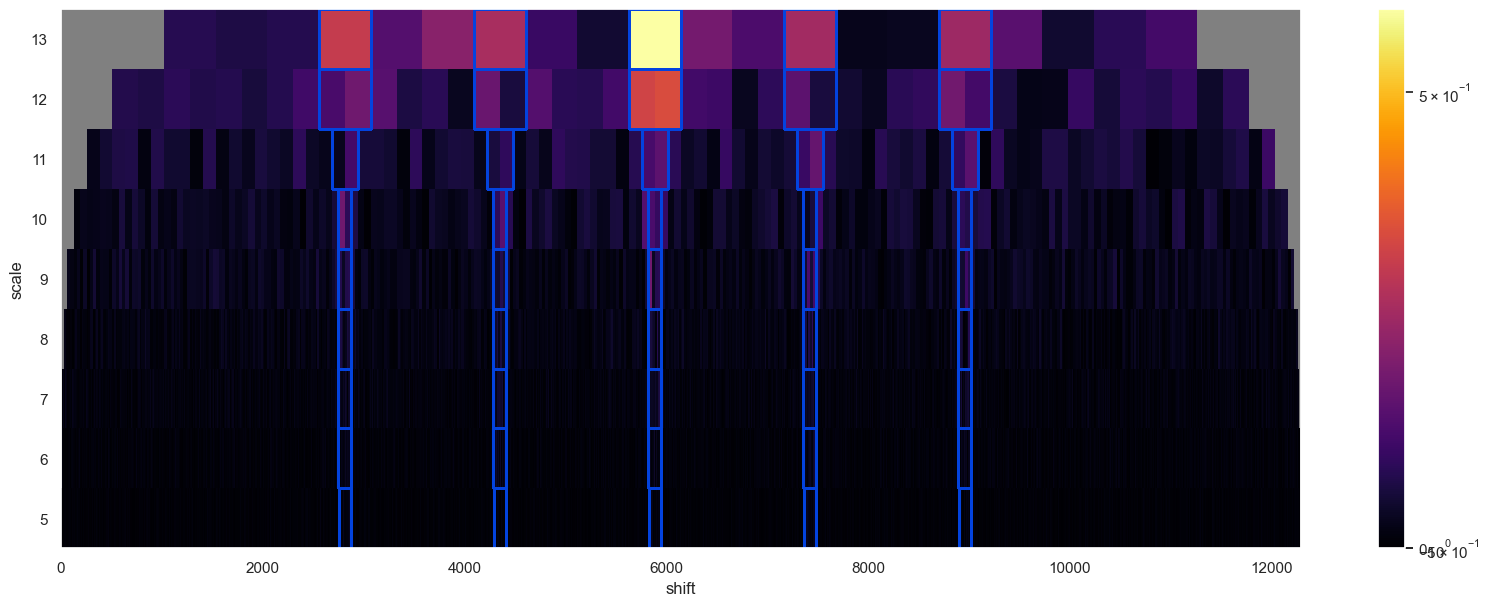

In [ ]:
plot_coef(WT.wt_coefs.values, j1=5, j2=13, leader=False, vmin=0, gamma=.6, nan_idx=wt_idx)

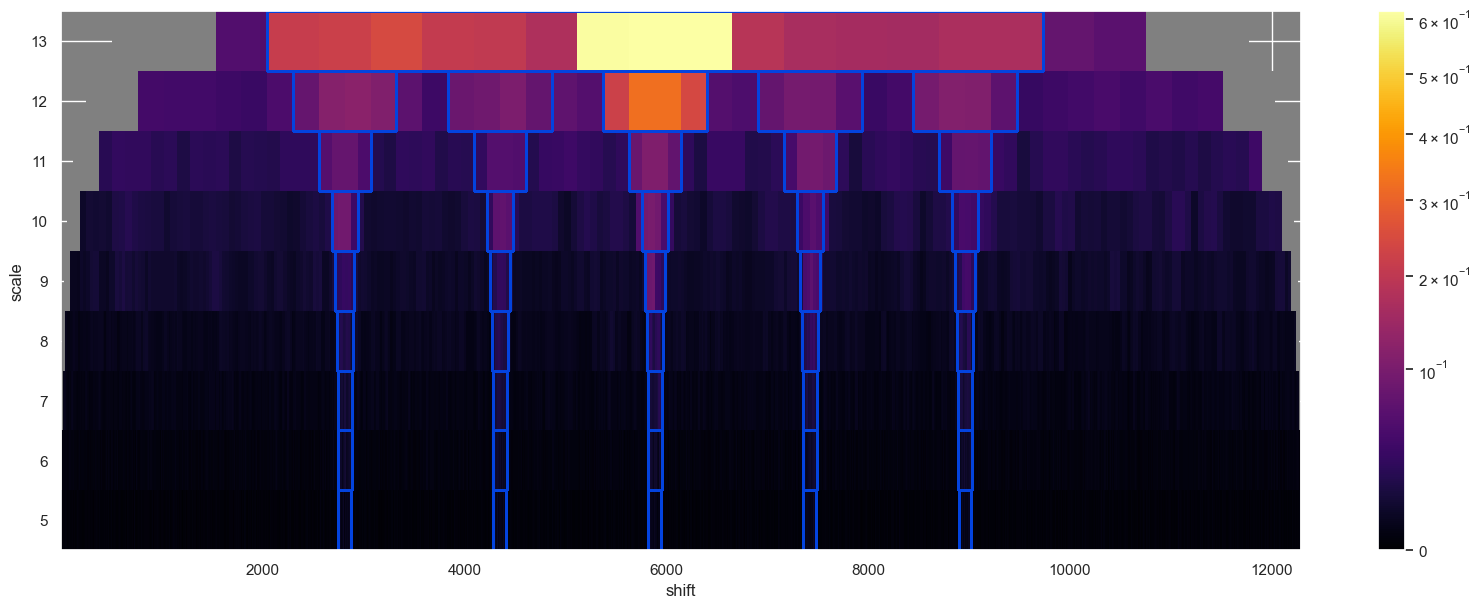

In [ ]:
plot_coef(WT.wt_leaders.values, j1=5, j2=13, leader=True, gamma=.6, nan_idx=leader_idx)

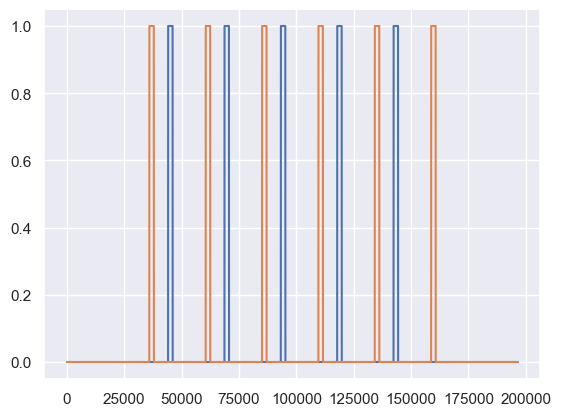

In [ ]:
# mask = create_mask3(N, 4, (N + 1) // 100, 13)
# plt.plot(mask)
mask = create_mask3(N, 5, (N + 1) // 100, 13)
plt.plot(mask)
mask = create_mask3(N, 6, (N + 1) // 100, 13)
plt.plot(mask)

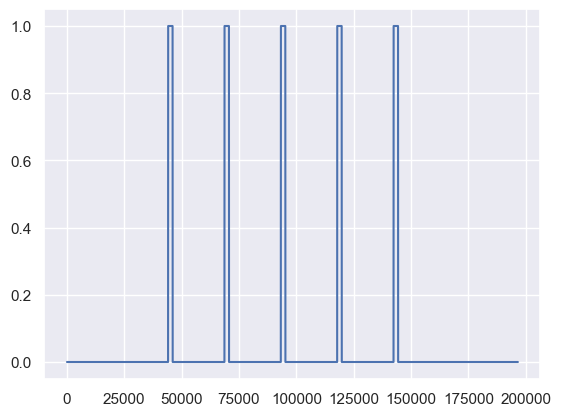

In [ ]:
mask = create_mask3(N, 5, (N + 1) // 100, 13)
plt.plot(mask)

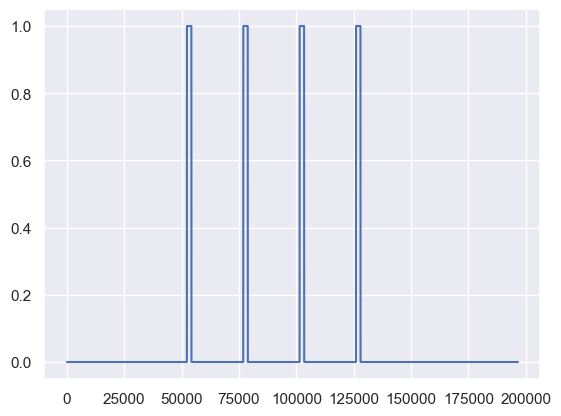

In [ ]:
# df = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, countgrid=np.arange(1, 6), n_rep=5, n_jobs=8)
df = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, n_rep=1, n_jobs=1)